In [33]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [34]:
import torch.nn
import numpy as np
from matplotlib import pyplot as plt

torch.__version__

'2.2.1+cu121'

In [61]:
device = "cuda" if torch.cuda.is_available() == True else "cpu"
print(device)

cpu


In [35]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
# even though it is a vector now (while it should be a feature matrix)
# therefore, we unsqueeze it in order not to run into dimensionality issues
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias



In [36]:
X[: 10], y[: 10]
# X.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [37]:
len(X), len(y)

(50, 50)

In [38]:
train_split = int(0.8 * len(X))

X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [39]:
def plot_predictions2(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

In [40]:
# plot_predictions2()

In [41]:
from torch import nn

class LinearRegressionModel(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.weights * x + self.bias


In [59]:
# create a linear model by subclassing nn.Module
# an alternative approach to the model designed in the previous cell

class LinearRegressionModelV2(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # this time we exploit nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()


(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [60]:
# check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [62]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

In [42]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()

list(model_0.parameters())

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [43]:
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [44]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

In [45]:
# plot_predictions2(predictions=y_preds)

In [46]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [47]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [48]:
epochs = 200

# # put data on the target device (device agnostic code for data)
# # uncomment this bloch if your data are set to different devices
# X_train = X_train.to(device)
# y_train = y_train.to(device)
# X_test = X_test.to(device)
# y_test = y_test.to(device)


# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  # set the model to training mode
  model_0.train()
  # forward pass
  y_pred = model_0(X_train)
  # calculate the loss
  loss = loss_fn (y_pred, y_train)
  # print(f"Loss: {loss}")
  # optimizer zero grad
  optimizer.zero_grad()
  # perform backpropagation and gradient calculation
  loss.backward()
  # step the optimizer (perform gradient descent, updates parameters
  # using the gradients computed in the previous step)
  optimizer.step()

  model_0.eval()

  with torch.inference_mode():
    # forward pass
    test_pred = model_0(X_test)

    test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
      epoch_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)
      print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
      print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [49]:
# ideal parameters (weight, bias)
weight, bias

print(model_0.state_dict())
print()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])



In [50]:
# epoch_count, type(loss_values), type(test_loss_values)

In [51]:
arr_loss_values = torch.tensor(loss_values).numpy()
# arr_loss_values

Text(0.5, 1.0, 'Training and Test Loss Curves')

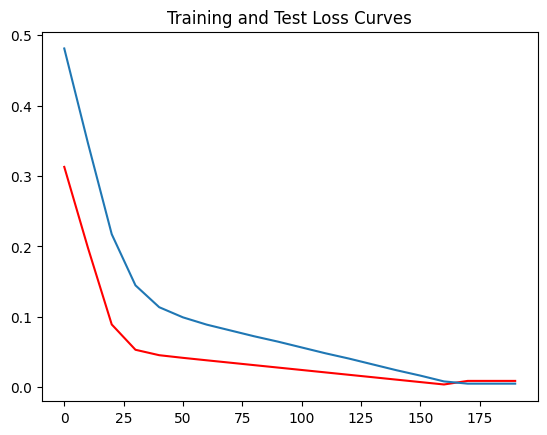

In [52]:
# plot the loss curves
plt.plot(epoch_count, arr_loss_values, c="r", label="Training Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and Test Loss Curves")

In [ ]:
# plot_predictions2(predictions=y_preds)

In [ ]:
# plot_predictions2(predictions=test_pred)

## 3 Main Ways to Save a Pytorch Model

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# Loading PyTorch model

loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# check if the saved and loaded models produce the same results
test_pred == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

cpu
